In [1]:
import pandas as pd 
import numpy as np 
from src.utils.preprocess import get_videoid

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

import yaml
with open("../../src/configs.yml", "r") as configs:
    configs = yaml.safe_load(configs)

ROOTPATH = configs["ROOTPATH"]
DATAPATH = configs["DATAPATH"]
ROOTPATH2 = configs["ROOTPATH2"]
OUTPATH = "../../output/results-summary-121224/"

START = configs["START"]
END = configs["END"]
print(configs)
print(START)
print(END)

{'ROOTPATH': '/Users/yijingch/Documents/GITHUB/invisible-public/', 'ROOTPATH2': '/Users/yijingch/Documents/GITHUB/dd-full/', 'DATAPATH': '/Users/yijingch/Documents/GITHUB/dd-full/data/', 'DATAPATH2': '/Users/yijingch/Documents/GITHUB/collect-youtube-content/data/', 'INDEXPATH': '/Users/yijingch/Documents/GITHUB/dd-full/index/', 'START': datetime.datetime(2018, 5, 1, 0, 0), 'END': datetime.datetime(2023, 5, 1, 0, 0)}
2018-05-01 00:00:00
2023-05-01 00:00:00


In [2]:
view_all = pd.read_csv(DATAPATH + "youtube/yt_watch.csv", sep=";")
view_all = view_all[["respondent_id","titleUrl","channel_url", "timestamp"]].rename(columns={"titleUrl":"video_url"})
view_all["channel_id"] = view_all["channel_url"].map(lambda x: x.split("/")[-1] if str(x)!= "nan" else np.NaN)
view_all["video_id"] = view_all["video_url"].map(lambda x: get_videoid(x))
# view_all = view_all.dropna(subset = ["respondent_id", "video_id", "channel_id"])[["respondent_id","channel_id","video_id","timestamp"]]
view_all = view_all[["respondent_id","channel_id","video_id","timestamp"]] # no longer dropna 

subscribe_all = pd.read_csv(DATAPATH + "youtube/yt_subscriptions.csv", sep=";")[["respondent_id","channel_id"]]

comment_all = pd.read_csv(DATAPATH + "youtube/yt_comments_from2018may_to2023may_new.csv", sep=";").rename(columns={"snippet.channelId":"channel_id"})
comment_all = comment_all[["respondent_id","video_id", "channel_id"]] # no longer drop na
comment_public = pd.read_pickle(DATAPATH + "youtube/yt_comments_public_061824.pkl")

view_all["timestamp"] = pd.to_datetime(view_all["timestamp"])
view_all = view_all[(view_all["timestamp"]>=START)&(view_all["timestamp"]<=END)].copy()

comment_public["timestamp"] = pd.to_datetime(comment_public["published_at"]).dt.tz_localize(None)
comment_public = comment_public[(comment_public["timestamp"]>=START)&(comment_public["timestamp"]<=END)].copy()
# subscribing data cannot be filtered; sample comment is already filtered

In [3]:
THESE_VIEWERS = set(view_all["respondent_id"].tolist())
THESE_SUBSCRIBERS = set(subscribe_all["respondent_id"].tolist())
THESE_COMMENTERS = set(comment_all["respondent_id"].tolist())

print("# of viewers:", len(THESE_VIEWERS))
print("# of subscribers:", len(THESE_SUBSCRIBERS))
print("# of commenters:", len(THESE_COMMENTERS))

# of viewers: 690
# of subscribers: 680
# of commenters: 314


In [4]:
pol_df = pd.read_csv(DATAPATH + "survey/pol_survey_cleaned_NEW_INCLUDEALL.csv").rename(columns={"user_id":"respondent_id"})

# get new weights [new!]
pol_df.drop(columns=["weight"], inplace=True)
new_weights = pd.read_spss(DATAPATH + "survey/TK_DataDonation_eng.sav")[["respondent_id","weight"]]
new_weights["respondent_id"] = new_weights["respondent_id"].map(lambda x: int(x))
pol_df = pol_df.merge(new_weights, on="respondent_id", how="left")

print(pol_df.columns)
set1 = set(view_all["respondent_id"].unique()).union(set(subscribe_all["respondent_id"].unique())).union(set(comment_all["respondent_id"].unique()))
set2 = set1.intersection(set(pol_df["respondent_id"].unique()))
print(len(set2))
# print(len(pol_df))

Index(['respondent_id', 'gender', 'birth_year', 'education', 'fb_freq',
       'ig_freq', 'tw_freq', 'yt_freq', 'lk_freq', 'tt_freq', 'sp_freq',
       'sns_view_politics', 'sns_view_politics_friends',
       'sns_view_politics_disagree', 'sns_view_politics_progov',
       'sns_view_politics_antigov', 'seek_politics_tv', 'seek_politics_radio',
       'seek_politics_newpp', 'seek_politics_sites', 'seek_politics_sns',
       'seek_politics_convo', 'talk_politics_frfa', 'align_politics_frfa',
       'interest_politics', 'vote_party_2022', 'would_go_vote_sunday',
       'would_vote_party_sunday', 'know_sppt_fdsz', 'know_sppt_mszp',
       'know_sppt_jbbk', 'know_sppt_lmp', 'know_sppt_dk', 'know_sppt_mtum',
       'know_sppt_mhzk', 'know_relate_fdsz', 'know_relate_mszp',
       'know_relate_jbbk', 'know_relate_lmp', 'know_relate_dk',
       'know_relate_mtum', 'know_relate_mhzk', 'feel_thm_fdsz',
       'feel_thm_mszp', 'feel_thm_jbbk', 'feel_thm_lmp', 'feel_thm_dk',
       'feel_thm_mtum',

In [5]:
channel_labels_all = pd.read_excel(ROOTPATH2 + "index/yt_polclass_20240627.xlsx")
channel_labels_all

label_col = "classification_lvl1_4cat"
LABEL_MAP = {
    1: 0, # neutral 
    2: -1, # anti-gov 
    3: 1, # pro-gov
}

channel_labels = channel_labels_all[channel_labels_all[label_col].isin(LABEL_MAP.keys())]

CHANNEL_LABEL_MAP = {}
for lab,val in LABEL_MAP.items():
    channel_subdf = channel_labels[channel_labels[label_col]==lab]
    these_channels = set(channel_subdf["channel_id"].tolist())
    print(lab, val, "# of channels", len(these_channels))
    for this_ch in these_channels:
        CHANNEL_LABEL_MAP[this_ch] = val 

CHANNEL_LABEL_MAP["UCKY8HrMpm32WAMK0lauLAZA"] = {"before":-1, "after":1} 

1 0 # of channels 149
2 -1 # of channels 276
3 1 # of channels 139


In [6]:
these_channels = CHANNEL_LABEL_MAP.keys()
pol_view = view_all[view_all["channel_id"].isin(these_channels)].copy()
pol_subscribe = subscribe_all[subscribe_all["channel_id"].isin(these_channels)].copy()
pol_comment = comment_all[comment_all["channel_id"].isin(these_channels)].copy()
pol_comment_public = comment_public[comment_public["channel_id"].isin(these_channels)].copy()

In [7]:
# aggregate by user
aggr_view = pol_view.groupby("respondent_id").agg({"video_id":lambda x:len(set(x))}).reset_index()
aggr_subscribe = pol_subscribe.groupby("respondent_id").agg({"channel_id":lambda x:len(set(x))}).reset_index()
aggr_comment = pol_comment.groupby("respondent_id").agg({"video_id":lambda x:len(set(x))}).reset_index()

In [8]:
def bin_variable(val, var_range):
    out = 0
    if not np.isnan(val):
        if val <= var_range[1] and val >= var_range[0]:
            out = 1
    return out

In [9]:
cols = ["respondent_id", "weight", "gender", "age", "interest_politics", "education", "feel_thm_fdsz", "lftRght"]
reg_table = pol_df[cols].merge(aggr_view, how="left").rename(columns={"video_id":"view_counts"})
reg_table = reg_table.merge(aggr_subscribe, how="left").rename(columns={"channel_id":"subscribe_counts"})
reg_table = reg_table.merge(aggr_comment, how="left").rename(columns={"video_id":"comment_counts"})

# replace missing value
reg_table["view_counts"] = reg_table["view_counts"].replace(np.NaN, 0)
reg_table["comment_counts"] = reg_table["comment_counts"].replace(np.NaN, 0)
reg_table["subscribe_counts"] = reg_table["subscribe_counts"].replace(np.NaN, 0)

reg_table["feel_thm_fdsz"] = reg_table["feel_thm_fdsz"].replace(np.NaN, 5)
reg_table["lftRght"] = reg_table["lftRght"].replace(np.NaN, 4)

# compute extremity values
reg_table["extreme_lftRght"] = reg_table["lftRght"].map(lambda x: abs(x-4))
reg_table["extreme_antiPro"] = reg_table["feel_thm_fdsz"].map(lambda x:abs(x-5))

In [10]:
reg_table["if_left"] = reg_table["lftRght"].map(lambda x: bin_variable(x, [1,3]))
reg_table["if_center"] = reg_table["lftRght"].map(lambda x: bin_variable(x, [4,4]))
reg_table["if_right"] = reg_table["lftRght"].map(lambda x: bin_variable(x, [5,7]))
reg_table["if_antigov"] = reg_table["feel_thm_fdsz"].map(lambda x: bin_variable(x, [0,2]))
reg_table["if_neutral"] = reg_table["feel_thm_fdsz"].map(lambda x: bin_variable(x, [3,7]))
reg_table["if_progov"] = reg_table["feel_thm_fdsz"].map(lambda x: bin_variable(x, [8,10]))

print("left-group:", len(reg_table[reg_table["if_left"]==1]))
print("center-group:", len(reg_table[reg_table["if_center"]==1]))
print("right-group:", len(reg_table[reg_table["if_right"]==1]))

print("progov-group:", len(reg_table[reg_table["if_progov"]==1]))
print("neutral-group:", len(reg_table[reg_table["if_neutral"]==1]))
print("antigov-group:", len(reg_table[reg_table["if_antigov"]==1]))

left-group: 177
center-group: 324
right-group: 257
progov-group: 114
neutral-group: 294
antigov-group: 350


## add timespan

### old --only use viewing activity!

In [11]:
import math
from datetime import timedelta

def calculate_overlap(start1, end1, start2, end2):
    latest_start = max(start1, start2)
    earliest_end = min(end1, end2)

    if latest_start > earliest_end:
        return np.NaN
    elif earliest_end == latest_start:
        return np.NaN
    else:
        overlap = earliest_end - latest_start
        if pd.isnull(overlap):
            return np.NaN 
        else:
            return math.ceil(overlap/np.timedelta64(1,"M"))

In [12]:
# old -- only use viewing activity

# view_all = pd.read_csv(DATAPATH + "youtube/yt_watch.csv", sep=";")
# view_all = view_all[["respondent_id","titleUrl","channel_url", "timestamp"]].rename(columns={"titleUrl":"video_url"})
# view_all["channel_id"] = view_all["channel_url"].map(lambda x: x.split("/")[-1] if str(x)!= "nan" else np.NaN)
# view_all["video_id"] = view_all["video_url"].map(lambda x: get_videoid(x))
# view_all = view_all.dropna(subset = ["respondent_id", "video_id", "channel_id"])[["respondent_id","channel_id","video_id","timestamp"]]
# view_all["timestamp"] = pd.to_datetime(view_all["timestamp"])
# pol_view = view_all[view_all["channel_id"].isin(these_channels)].copy()

In [13]:
# from datetime import datetime
# aggr_view2 = pol_view.groupby("respondent_id").agg({"timestamp":lambda x:list(x)}).reset_index()
# aggr_view2["start"] = aggr_view2["timestamp"].map(lambda x: min(x))
# aggr_view2["end"] = aggr_view2["timestamp"].map(lambda x: max(x))
# aggr_view2["timespan"] = aggr_view2.apply(lambda x: calculate_overlap(x["start"], x["end"], pd.to_datetime(START), pd.to_datetime(END)), axis=1)

# reg_table = reg_table.merge(aggr_view2[["respondent_id", "timespan"]], how="left")
# reg_table = reg_table[reg_table["respondent_id"].isin(set2)]

### new -- use viewing and commenting!

In [14]:
def get_minmax_activity(date1, date2, mode="min"):
    out = np.NaN
    if not pd.isnull(date1) and pd.isnull(date2):
        out = date1
    elif pd.isnull(date1) and not pd.isnull(date2):
        out = date2 
    else:
        if mode == "min":
            out = min(date1, date2)
        if mode == "max":
            out = max(date1, date2)
    return out

resp_activity = pd.read_csv("../../data/yt_resplevel_data.csv")
for col in ["first_video", "last_video", "first_comment", "last_comment"]:
    resp_activity[col] = pd.to_datetime(resp_activity[col])
resp_activity["first_activity"] = resp_activity.apply(lambda x: get_minmax_activity(x["first_video"],x["first_comment"],mode="min"), axis=1)
resp_activity["last_activity"] = resp_activity.apply(lambda x: get_minmax_activity(x["last_video"],x["last_comment"],mode="max"), axis=1)
# resp_activity["first_activity"] = resp_activity.apply(lambda x: min(x["first_video"],x["first_comment"]),axis=1)
# resp_activity["last_activity"] = resp_activity.apply(lambda x: min(x["last_video"],x["last_comment"]),axis=1)
resp_activity["timespan"] = resp_activity.apply(lambda x: calculate_overlap(x["first_activity"], x["last_activity"], pd.to_datetime(START), pd.to_datetime(END)), axis=1)


In [15]:
reg_table = reg_table.merge(resp_activity[["respondent_id", "timespan"]], how="left")
reg_table = reg_table[reg_table["respondent_id"].isin(set2)]
# reg_table["timespan"] = reg_table["timespan"].fillna(0)

## fill NA timespan

In [16]:
print(reg_table["timespan"].mean())

na_people = reg_table[reg_table["timespan"].isna()]["respondent_id"].unique()
print(len(na_people))

# people who only has one activity 
print(view_all[view_all["respondent_id"].isin(na_people)]["respondent_id"].tolist())
print(comment_all[comment_all["respondent_id"].isin(na_people)]["respondent_id"].tolist())
print(resp_activity[resp_activity["first_activity"]==resp_activity["last_activity"]]["respondent_id"].tolist())

50.66571834992887
32
[1072184]
[397292, 824358, 1084965, 1228983]
[1072184, 397292, 485517, 722586, 824358, 1084965, 1143822]


In [17]:
IMPUTE_DICT = reg_table[["respondent_id","timespan"]].set_index("respondent_id").to_dict()["timespan"]
IMPUTE_DICT

one_activity_resps = [1072184, 397292, 824358, 1084965]
for resp,t in IMPUTE_DICT.items():
    if str(t) == "nan":
        if resp in one_activity_resps:
            IMPUTE_DICT[resp] = 1
        else:
            IMPUTE_DICT[resp] = round(reg_table["timespan"].mean())
reg_table["timespan_imputed"] = reg_table["respondent_id"].map(lambda x: IMPUTE_DICT[x])

Text(0.5, 0, 'timespan: # of months')

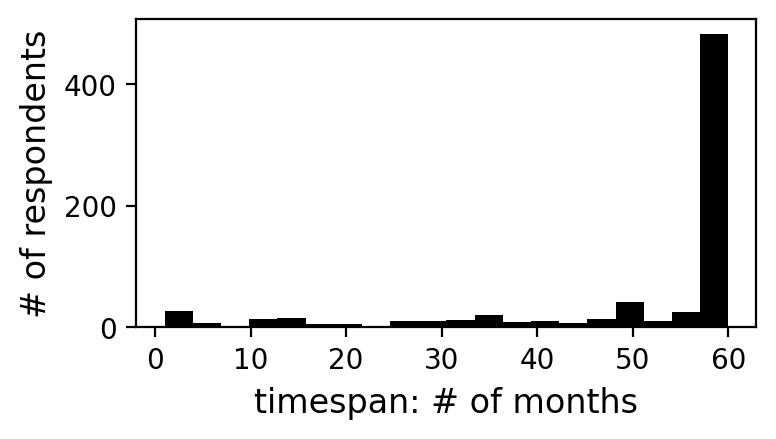

In [18]:
fig,ax = plt.subplots(figsize=(4,2))
plt.hist(reg_table["timespan_imputed"], bins=20, color="black")
plt.ylabel("# of respondents", fontsize=12)
plt.xlabel("timespan: # of months", fontsize=12)

Text(0.5, 0, 'timespan: # of months')

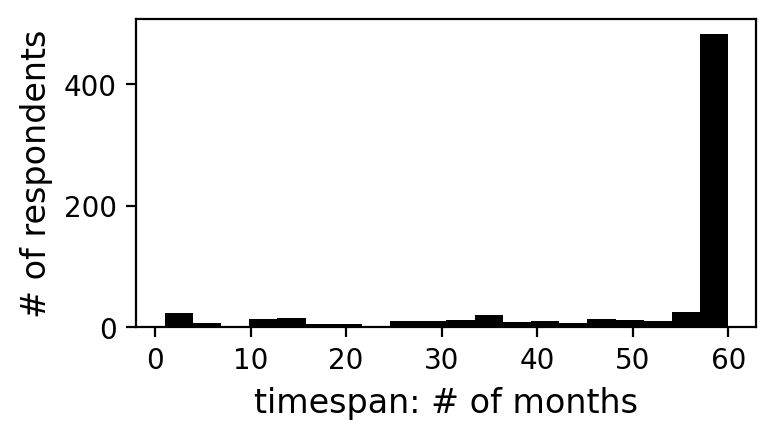

In [19]:
fig,ax = plt.subplots(figsize=(4,2))
plt.hist(reg_table["timespan"], bins=20, color="black")
plt.ylabel("# of respondents", fontsize=12)
plt.xlabel("timespan: # of months", fontsize=12)
# plt.savefig(OUTPATH + "timespan_distribution.png", dpi=300, bbox_inches="tight")

In [20]:
print(len(reg_table))
print(len(reg_table[reg_table["timespan"]==0]))

735
0


## impute NA value of timespan

## add respondent filter

In [21]:
reg_table["if_view"] = reg_table["respondent_id"].map(lambda x: 1 if x in THESE_VIEWERS else 0)
reg_table["if_subscribe"] = reg_table["respondent_id"].map(lambda x: 1 if x in THESE_SUBSCRIBERS else 0)
reg_table["if_comment"] = reg_table["respondent_id"].map(lambda x: 1 if x in THESE_COMMENTERS else 0)

In [22]:
print(len(reg_table[reg_table["if_view"]==1]))
print(len(reg_table[reg_table["if_subscribe"]==1]))
print(len(reg_table[reg_table["if_comment"]==1]))

690
680
314


In [23]:
reg_table.to_csv("../../output/reg_table_filter_ytb_activities_122324.csv", index=False)

## add channel categories breakdown

In [24]:
# reg_table = pd.read_csv("../../output/reg_table_filter_ytb_activities_121924.csv")

In [25]:
def get_channel_label(channel_id, label_map, before_after=""):
    if before_after == "":
        return label_map[channel_id]
    else:
        return label_map[channel_id][before_after]

def count_channel_label(channel_ls, label_map=CHANNEL_LABEL_MAP):
    label_ls = []
    for c in channel_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                lab = get_channel_label(c, label_map=label_map, before_after="after")
            else:
                lab = get_channel_label(c, label_map=label_map)
            label_ls.append(lab)
    label_counter = {-1:0, 0:0, 1:0}
    for l in label_ls:
        label_counter[l] += 1
    return label_counter

def count_channel_label_temporal(channel_time_ls, label_map=CHANNEL_LABEL_MAP):
    label_ls = []
    for c,time in channel_time_ls:
        if c in label_map.keys():
            if c == "UCKY8HrMpm32WAMK0lauLAZA":
                if time <= pd.to_datetime("2020-08-01 00:00:00"):
                    lab = get_channel_label(c, label_map=label_map, before_after="before")
                else:
                    lab = get_channel_label(c, label_map=label_map, before_after="after")
            else:
                lab = get_channel_label(c, label_map=label_map)
            label_ls.append(lab)
    label_counter = {-1:0, 0:0, 1:0}
    for l in label_ls:
        label_counter[l] += 1
    return label_counter


In [26]:
aggr_func1 = {"channel_id_time": lambda x: list(x)}
aggr_func2 = {"channel_id":lambda x: list(x)}
pol_view["channel_id_time"] = pol_view.apply(lambda x: (x["channel_id"], x["timestamp"]), axis=1)
view_aggr = pol_view.groupby("respondent_id").agg(aggr_func1).reset_index()
subscribe_aggr = pol_subscribe.groupby("respondent_id").agg(aggr_func2).reset_index()
comment_aggr = pol_comment.groupby("respondent_id").agg(aggr_func2).reset_index()

In [27]:
view_aggr["view_labs"] = view_aggr["channel_id_time"].map(lambda x: count_channel_label_temporal(x))
subscribe_aggr["subscribe_labs"] = subscribe_aggr["channel_id"].map(lambda x: count_channel_label(x))
comment_aggr["comment_labs"] = comment_aggr["channel_id"].map(lambda x: count_channel_label(x))


In [28]:
reg_table_bd = reg_table.merge(view_aggr, on="respondent_id", how="left")
reg_table_bd = reg_table_bd.merge(subscribe_aggr, on="respondent_id", how="left")
reg_table_bd = reg_table_bd.merge(comment_aggr, on="respondent_id", how="left")

for activity in ["view", "subscribe", "comment"]:
    reg_table_bd[f"{activity}_anti"] = reg_table_bd[f"{activity}_labs"].map(lambda x:x[-1] if str(x)!="nan" else 0)
    reg_table_bd[f"{activity}_netr"] = reg_table_bd[f"{activity}_labs"].map(lambda x:x[0] if str(x)!="nan" else 0)
    reg_table_bd[f"{activity}_pro"] = reg_table_bd[f"{activity}_labs"].map(lambda x:x[1] if str(x)!="nan" else 0)

reg_table_bd.drop(columns=["channel_id_time", "channel_id_x", "channel_id_y", "view_labs"], inplace=True)


In [29]:
reg_table_bd.to_csv("../../output/reg_table_filter_ytb_activities_channel_catg_counts_122324.csv", index=False)

In [30]:
reg_table_bd["timespan_imputed"]

0      60.0
1      60.0
2      58.0
3      60.0
4      60.0
       ... 
730    13.0
731    59.0
732    60.0
733    27.0
734    60.0
Name: timespan_imputed, Length: 735, dtype: float64